In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fancy_round import fancy_round
from wb_api_wrapper import *
import numpy as np
import pandas as pd


C:\Users\Admin\Anaconda3\lib\site-packages\pandas\io\wb.py:19: FutureWarning: 
The pandas.io.wb module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


### Data from WDI

In [3]:
groups = pd.read_csv("income_groups.csv",header =4,index_col=["Economy"], na_values="..", usecols=["Economy","Lending category"] )
wb_countries=groups.dropna().index

In [4]:
data_wb = get_wb("NY.GDP.PCAP.KN")#GDP per capita (constant LCU)
""" NY.GDP.MKTP.KD.ZG real growth ong serie
"NY.GDP.PCAP.PP.CD"  ppp gdp pc short series
NY.GDP.MKTP.KD 
NY.GDP.PCAP.KD""";



### Data from PWT 

In [5]:
iso_to_wb =pd.read_csv('iso3_to_wb_name.csv',index_col="iso3",squeeze=True);

def replace_with_warning(series_in,dico):
    out=series_in.replace(dico)
    bads = [c for c in out if c not in dico.tolist()]
    if bads !=[]:
        warnings.warn("\nbad country names : "+",".join(bads))
    return out

if False:
    #Data on real GDP per capita. Ends in 2002
    pwt = pd.read_csv("FebPwtExport11172015.csv").drop("VariableCode",axis=1).rename(columns={"YearCode":"year"})
    pwt["country"] = replace_with_warning(pwt["RegionCode"],iso_to_wb)

    #pivots data
    hop=pwt.set_index(["country"])[["year","AggValue"]]
    data_pwt=hop.pivot(columns="year",values="AggValue")

else:
    #Data on pop and reald gdp PPP. Ends in 2010
    pwt= pd.read_csv("pwt_rgdpe_pop_8.1.csv").rename(columns={"YearCode":"year"})
    pwt["country"] = replace_with_warning(pwt["RegionCode"],iso_to_wb)

    gdp=pwt.set_index(["country"]).query("VariableCode=='rgdpe'")[["year","AggValue"]].pivot(columns="year",values="AggValue")
    pop=pwt.set_index(["country"]).query("VariableCode=='pop'")[["year","AggValue"]].pivot(columns="year",values="AggValue")
    data_pwt=gdp/pop


# Process the data

Series([], Name: year, dtype: float64)


count    142.000000
mean       1.878053
std        2.485629
min      -10.466629
25%        0.567514
50%        1.599204
75%        3.008227
max       11.195243
Name: 0, dtype: float64
Series([], Name: year, dtype: float64)


count    118.000000
mean       2.937205
std        3.158551
min       -5.734340
25%        1.140960
50%        2.798386
75%        4.735227
max       12.817878
Name: 0, dtype: float64


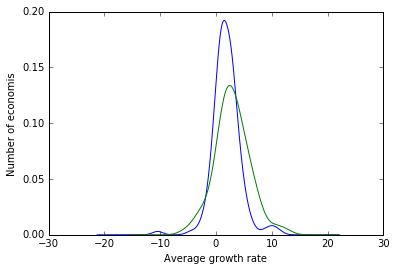

In [6]:
#histograms 
for data_ in [data_wb, data_pwt]:
    data= data_.ix[data_.index.isin(wb_countries)] #Takes only actual countries (filters things like LAC out and developed countries)
    
    
    gdp_now  = mrv(data)
    gdp_then = lrv(data)

    now = mr_year(data).astype('float64')
    then = lr_year(data).astype('float64').clip(lower=now-30)

    pd.DataFrame([then,gdp_then, now, gdp_now],index=["year","GDPpc","year","GDPpc"]).T.to_excel("growth.xlsx")
    growth_rates=(np.power(gdp_then/gdp_now, -1/(now-then))-1)*100

    #removes countries with little data
    print((now-then)[(now-then<4)])
    growth_rates[(now-then<4)]=np.nan


    #Stats
    ax=(1*growth_rates).plot.kde(grid="off")
    ax.set_xlabel("Average growth rate")
    ax.set_ylabel("Number of economis")
    print("\n")
    print((1*growth_rates).describe())
    

In [19]:
np.arange(0,1,1/100)

array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,
        0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,
        0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,
        0.27,  0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,
        0.36,  0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,
        0.45,  0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,
        0.54,  0.55,  0.56,  0.57,  0.58,  0.59,  0.6 ,  0.61,  0.62,
        0.63,  0.64,  0.65,  0.66,  0.67,  0.68,  0.69,  0.7 ,  0.71,
        0.72,  0.73,  0.74,  0.75,  0.76,  0.77,  0.78,  0.79,  0.8 ,
        0.81,  0.82,  0.83,  0.84,  0.85,  0.86,  0.87,  0.88,  0.89,
        0.9 ,  0.91,  0.92,  0.93,  0.94,  0.95,  0.96,  0.97,  0.98,  0.99])

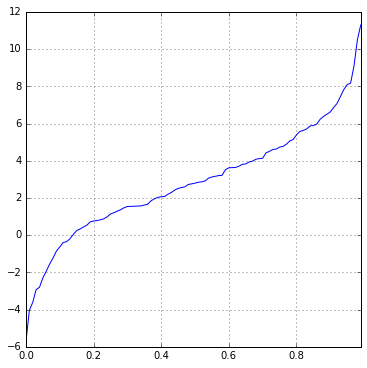

In [27]:
a=growth_rates.quantile(np.arange(0,1,1/100))
a.plot(figsize=(6,6))
# plt.hlines(y=np.arange(-6,12,1), xmin=0,xmax=1)
plt.grid("on")
plt.savefig("growth_rates_cdf.png")
a.to_csv("growth_rates_cdf.csv")

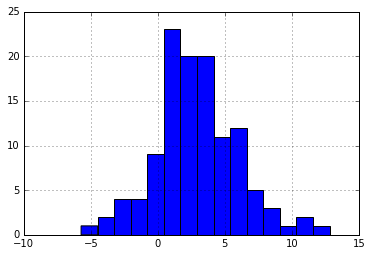

In [8]:
growth_rates.hist(bins=15)


In [9]:
growth_rates.quantile([0.25,1/3,2/3,0.75]+np.arange(0,1,0.1).tolist())

0.250000    1.140960
0.333333    1.571456
0.666667    3.938069
0.750000    4.735227
0.000000   -5.734340
0.100000   -0.630946
0.200000    0.760749
0.300000    1.543696
0.400000    2.066121
0.500000    2.798386
0.600000    3.624403
0.700000    4.137476
0.800000    5.394941
0.900000    6.629219
Name: 0, dtype: float64

In [10]:
### The World econoy as a whole grew less than countries individually on average
data_allcountries = data.dropna(axis=1)
(np.power(data_allcountries[1990].sum()/data_allcountries[2010].sum(), -1/(20))-1)*100

2.4609656206132868

In [11]:
(np.power(data[1960].sum()/data[2010].sum(), -1/(50))-1)*100

3.4437723825420319

In [12]:
import matplotlib.pylab as plt

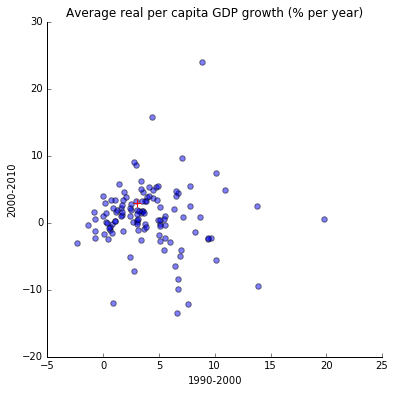

In [13]:
x=old_gr =(np.power(data_allcountries[2000]/data_allcountries[2010], -1/(10))-1)*100
y=new_gr =(np.power(data_allcountries[1990]/data_allcountries[2000], -1/(10))-1)*100
names_=x.index


fig= plt.figure(figsize=(6,6))

ax=plt.gca()
ax.scatter(old_gr,new_gr, s=30, alpha=0.5)

#ax.spines['bottom'].set_position("bottom")
ax.spines['right'].set_color('none')

ax.spines['top'].set_color('none')
#ax.spines['left'].set_position("left")

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')


ax.set_xlabel("1990-2000")
ax.set_ylabel("2000-2010")



ax.scatter(3,3,marker="+",color="red", s=70)

logical = False &( (old_gr<0 )| (old_gr>10) | (new_gr>10) | (new_gr<0) )
for label, x_, y_ in zip(names_[logical], x[logical], y[logical]):
    plt.annotate(
        label, 
        xy = (x_, y_), xytext = (10, 0),
        textcoords = 'offset points', ha = 'left', va = 'center',fontsize=13
        #bbox = nonedict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        #arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0')
    )


plt.title("Average real per capita GDP growth (% per year)")    
    
plt.savefig("growth_rates_scatter.png")


In [14]:
x=pd.DataFrame([then,gdp_then, now,gdp_now],index=["then","gdp_then","now","gdp_now"])
x["Congo, Dem. Rep."]

then        1980.000000
gdp_then     925.367228
now         2010.000000
gdp_now      384.504907
Name: Congo, Dem. Rep., dtype: float64

# Output

In [15]:
g=growth_rates.apply(fancy_round).dropna()
g.to_csv("growth_rates.csv")

g=g.reset_index()


#g.to_csv("list_growth_rates_range.csv",index=None)

#with open("Output.txt", "w") as text_file:
#    text_file.write(", ".join(g))


def arrange_in_n_columns(g,n=3):
    #Arrange over n columns
    for i in np.arange(0,n-np.mod(g.shape[0],n)):
        g.loc[len(g)+1]=" "
    return pd.DataFrame(g.reshape(3,g.shape[0]/n)).T

arrange_in_n_columns(g["country"]+" "+g[0].astype(str)+u"\u2014"+(2*g[0]).astype(str)).to_csv("growth_rates_range_three_columns.csv",header=None,index=None)    

arrange_in_n_columns(g["country"]+" "+(1.5*g[0]).apply(fancy_round).astype(str)).to_csv("growth_rates_15_three_columns.csv",header=None,index=None)  

In [16]:
#Unrelated line to compute discount factors. But mind numerical error, this is better done with analytical resolution
1000*(1/np.power((1.12),np.arange(0,19))).sum() / 1000*(1/np.power((1.12),np.arange(0,100))).sum()


76.995998895671718